In [2]:
from All_functions_simulation_univariate import * 
from sklearn.linear_model import QuantileRegressor

/Users/dm8341/anaconda3/lib/python3.10/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


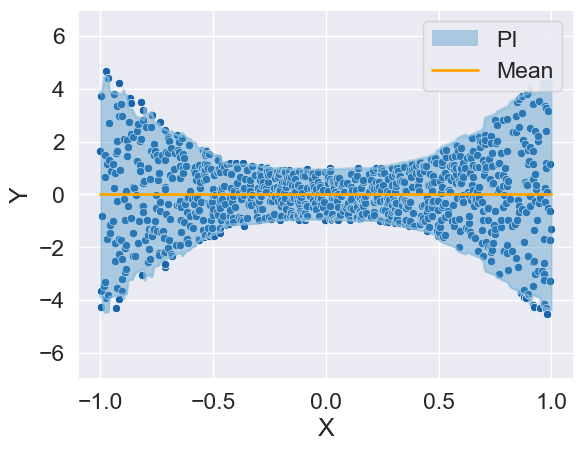

The overall coverage is 0.953
The mean bandwidth for testing data is 5.075814075226541


/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


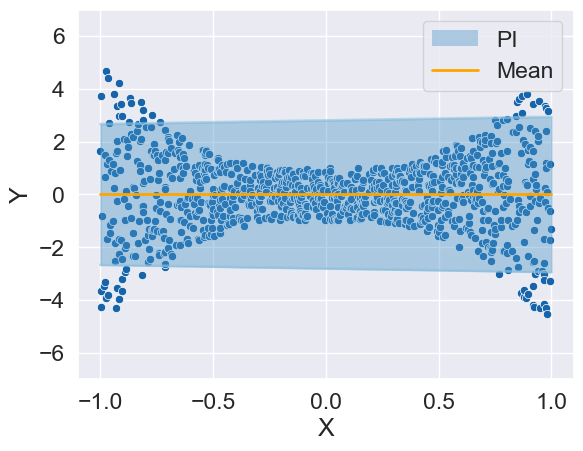

The overall coverage is 0.938
The mean bandwidth for testing data is 7.881222275744749


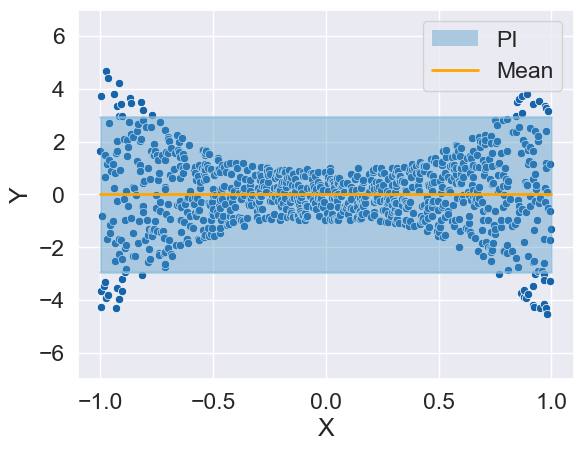

The overall coverage is 0.945
The mean bandwidth for testing data is 8.614758154613611


In [5]:
################################### SETUP 1 ###################################

##################### UTOPIA #####################

np.random.seed(5)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)


# Obtain mean estimator
known_mean = "True"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
# delta = 1
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-7,7])



##################### LQR #####################

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]


# Estimate the quantile
M_quantile = np.zeros(n_quantile).reshape(-1,1)

alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


M_test = np.zeros(n_test).reshape(-1,1)
V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-7,7])


##################### SPLIT CONFORMAL #####################

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_res = X[600:n_pre+n_opt+n_adj,:]
Y_res = Y[600:n_pre+n_opt+n_adj,:]
x_res = X_res[:,0]
y_res = Y_res[:,0]
n_res = X_res.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
x_test = X_test[:,0]
y_test = Y_test[:,0]
n_test = X_test.shape[0]


# Calculate the conformity scores
y_res_pred = np.zeros(n_res)
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
m_test = np.zeros(n_test)
M_test = m_test.reshape(-1,1)
v_test = (threshold**2)*np.ones(n_test)
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,ylim=[-7,7])

/Users/dm8341/anaconda3/lib/python3.10/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


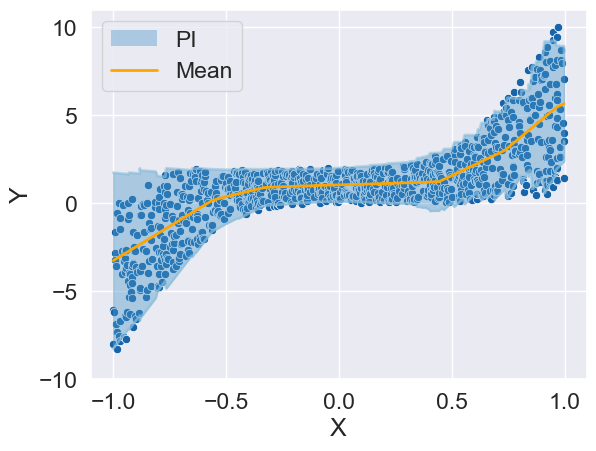

The overall coverage is 0.949
The mean bandwidth for testing data is 5.548917812977796


/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


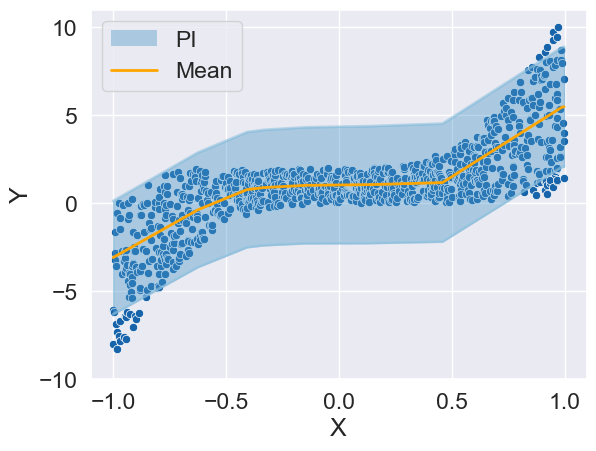

The overall coverage is 0.958
The mean bandwidth for testing data is 10.968996905514578


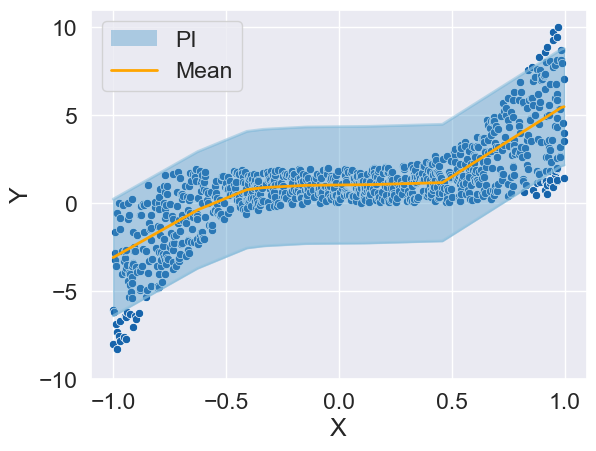

The overall coverage is 0.954
The mean bandwidth for testing data is 10.98704166012135


In [3]:
################################### SETUP 2 ###################################

##################### UTOPIA #####################

np.random.seed(0)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = 1+5*np.power(X, 3)+np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)


known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-10,11],legend_loc = 'upper left')




##################### LQR #####################

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]


# Estimate the mean using NN2
est_type = "NN2"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-10,11],legend_loc = 'upper left')


##################### SPLIT CONFORMAL #####################

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_res = X[600:n_pre+n_opt+n_adj,:]
Y_res = Y[600:n_pre+n_opt+n_adj,:]
x_res = X_res[:,0]
y_res = Y_res[:,0]
n_res = X_res.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
x_test = X_test[:,0]
y_test = Y_test[:,0]
n_test = X_test.shape[0]


# Estimate the mean using NN2
est_type = "NN2"
Y_res_pred, M_test = mean_est_2(est_type,X_lin,Y_lin,X_res,X_test)


# Calculate the conformity scores
y_res_pred = Y_res_pred[:,0]
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(n_test)
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,ylim=[-10,11],legend_loc = 'upper left')

/Users/dm8341/anaconda3/lib/python3.10/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


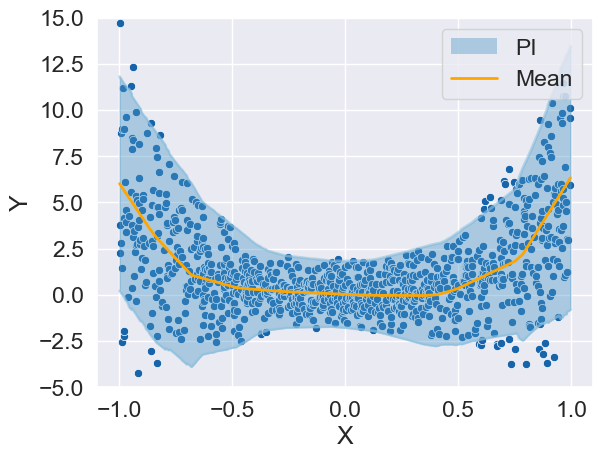

The overall coverage is 0.958
The mean bandwidth for testing data is 14.361006837375024


/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


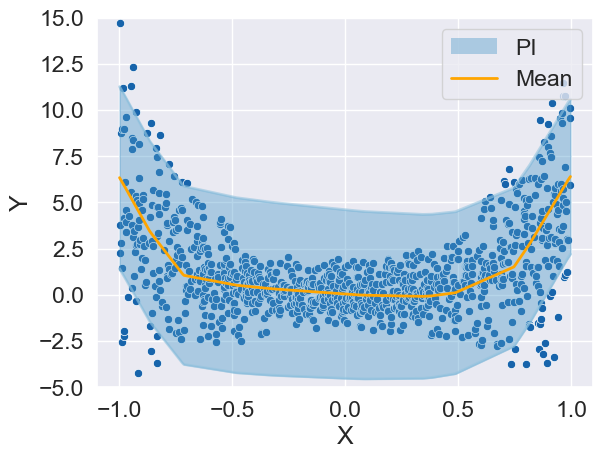

The overall coverage is 0.945
The mean bandwidth for testing data is 20.786821390854996


In [ ]:
################################### SETUP 3 ###################################

##################### UTOPIA #####################

np.random.seed(1)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

# X = np.random.uniform(-1, 1, n).reshape(-1, 1)
# Y = np.random.laplace(1+5*np.power(X, 3),np.sqrt(1+25*np.power(X, 4)) )
# Y = np.median(np.hstack([np.power(X, 2)+np.power(X, 4)+6,np.power(X, 2)+np.power(X, 4)-6,Y]),axis=1).reshape(-1, 1)

X = np.random.uniform(-1, 1, n).reshape(-1, 1)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X, 2)+5*np.power(X, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X, 4))

# Specify the bounds for Y
lower_bound = mean_Y - 2 * std_dev_Y
upper_bound = mean_Y + 2 * std_dev_Y

# Generate all Y values initially
Y = np.random.laplace(mean_Y, std_dev_Y)

# Correct values that fall out of bounds
while True:
    out_of_bounds = (Y < lower_bound) | (Y > upper_bound)
    if not np.any(out_of_bounds):
        break
    Y[out_of_bounds] = np.random.laplace(mean_Y[out_of_bounds], std_dev_Y[out_of_bounds])

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)

known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-5,15])


##################### LQR #####################

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_quantile = X[600:n_pre+n_opt+n_adj,:]
Y_quantile = Y[600:n_pre+n_opt+n_adj,:]
n_quantile = X_quantile.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
n_test = X_test.shape[0]

# Estimate the mean using NN2
est_type = "NN2"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)


# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,ylim=[-5,15])

##################### SPLIT CONFORMAL #####################

X_lin = X[0:600,:]
Y_lin = Y[0:600,:]
x_lin = X_lin[:,0]
y_lin = Y_lin[:,0]
n_lin = X_lin.shape[0]

X_res = X[600:n_pre+n_opt+n_adj,:]
Y_res = Y[600:n_pre+n_opt+n_adj,:]
x_res = X_res[:,0]
y_res = Y_res[:,0]
n_res = X_res.shape[0]

X_test = X[n_pre+n_opt+n_adj:,:]
Y_test = Y[n_pre+n_opt+n_adj:,:]
x_test = X_test[:,0]
y_test = Y_test[:,0]
n_test = X_test.shape[0]

# Estimate the mean using NN2
est_type = "NN2"
Y_res_pred, M_test = mean_est_2(est_type,X_lin,Y_lin,X_res,X_test)


# Calculate the conformity scores
y_res_pred = Y_res_pred[:,0]
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
v_test = (threshold**2)*np.ones(n_test)
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,ylim=[-5,15])